Preparación de Datos

In [ ]:
from scapy.all import rdpcap, IP, TCP
import pandas as pd

# ---------------------------
# Lista de PCAPs y labels
# ---------------------------
pcap_files = [
    ("Dataset/DoS-GoldenEye_attack.pcap", 1),
    ("Dataset/DoS-GoldenEye_benign.pcap", 0),
    ("Dataset/DoS-Hulk_attack.pcap", 2),
    ("Dataset/DoS-Hulk_benign.pcap", 0)
]

# ---------------------------
# Función para extraer paquetes
# ---------------------------
def pcap_to_dataframe(pcap_file, label):
    packets = rdpcap(pcap_file)
    data = []
    for pkt in packets:
        if IP in pkt:
            src_ip = pkt[IP].src
            dst_ip = pkt[IP].dst
            src_port = pkt[TCP].sport if TCP in pkt else None
            dst_port = pkt[TCP].dport if TCP in pkt else None
            proto = pkt[IP].proto
            timestamp = float(pkt.time)
            pkt_len = float(len(pkt))
            payload_len = float(len(pkt[TCP].payload)) if TCP in pkt else 0.0
            tcp_flags = pkt[TCP].flags if TCP in pkt else 0
            small_pkt = 1.0 if pkt_len < 100 else 0.0

            data.append({
                "timestamp": timestamp,
                "src_ip": src_ip,
                "dst_ip": dst_ip,
                "src_port": src_port,
                "dst_port": dst_port,
                "protocol": proto,
                "packet_len": pkt_len,
                "payload_len": payload_len,
                "tcp_flags": tcp_flags,
                "small_packet": small_pkt,
                "label": label
            })
    return pd.DataFrame(data)

# ---------------------------
# Procesar todos los PCAPs
# ---------------------------
dfs = []
for pcap_file, label in pcap_files:
    print(f"Cargando {pcap_file} ...")
    df = pcap_to_dataframe(pcap_file, label)
    dfs.append(df)

# ---------------------------
# Combinar todo en un dataset final
# ---------------------------
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_csv("Dataset/combined_DoS_dataset.csv", index=False)

print("Dataset combinado listo en combined_DoS_dataset.csv")
print(df_all.head())


Cargando Dataset/DoS-GoldenEye_attack.pcap ...
Cargando Dataset/DoS-GoldenEye_benign.pcap ...
Cargando Dataset/DoS-Hulk_attack.pcap ...
Cargando Dataset/DoS-Hulk_benign.pcap ...
Dataset combinado listo en combined_DoS_dataset.csv
      timestamp        src_ip        dst_ip  src_port  dst_port  protocol  \
0  1.698376e+09  192.168.1.11  192.168.1.10     47372        80         6   
1  1.698376e+09  192.168.1.11  192.168.1.10     47370        80         6   
2  1.698376e+09  192.168.1.11  192.168.1.10     47372        80         6   
3  1.698376e+09  192.168.1.11  192.168.1.10     47370        80         6   
4  1.698376e+09  192.168.1.11  192.168.1.10     47372        80         6   

   packet_len  payload_len tcp_flags  small_packet  label  
0        74.0          0.0         S           1.0      1  
1        74.0          0.0         S           1.0      1  
2        66.0          0.0         A           1.0      1  
3        66.0          0.0         A           1.0      1  
4      

In [ ]:
import pandas as pd
import numpy as np

# ---------------------------
# Cargar dataset combinado
# ---------------------------
df = pd.read_csv("combined_DoS_dataset.csv")

# ---------------------------
# Parámetros de ventana
# ---------------------------
WINDOW_SIZE = 0.5  # en segundos

# ---------------------------
# Ordenar por timestamp
# ---------------------------
df = df.sort_values("timestamp").reset_index(drop=True)

# ---------------------------
# Crear ventana
# ---------------------------
start_time = df['timestamp'].min()
end_time = df['timestamp'].max()
windows = np.arange(start_time, end_time, WINDOW_SIZE)

features = []

for i in range(len(windows)-1):
    w_start = windows[i]
    w_end = windows[i+1]
    window_df = df[(df['timestamp'] >= w_start) & (df['timestamp'] < w_end)]
    
    if len(window_df) == 0:
        continue
    
    total_packets = len(window_df)
    total_bytes = window_df['packet_len'].sum()
    avg_packet_size = window_df['packet_len'].mean()
    avg_payload_size = window_df['payload_len'].mean()
    packet_rate = total_packets / WINDOW_SIZE
    small_packet_ratio = window_df['small_packet'].mean()
    
    syn_count = ((window_df['tcp_flags'].astype(str).str.contains('S'))).sum()
    ack_count = ((window_df['tcp_flags'].astype(str).str.contains('A'))).sum()
    fin_count = ((window_df['tcp_flags'].astype(str).str.contains('F'))).sum()
    
    # Etiqueta predominante en la ventana (mayoría)
    label = window_df['label'].mode()[0]
    
    features.append({
        'window_id': i,
        'start_time': w_start,
        'end_time': w_end,
        'total_packets': total_packets,
        'total_bytes': total_bytes,
        'avg_packet_size': avg_packet_size,
        'avg_payload_size': avg_payload_size,
        'packet_rate': packet_rate,
        'small_packet_ratio': small_packet_ratio,
        'syn_count': syn_count,
        'ack_count': ack_count,
        'fin_count': fin_count,
        'label': label
    })

# ---------------------------
# Crear DataFrame de features
# ---------------------------
df_features = pd.DataFrame(features)
df_features.to_csv("Dataset/DoS_window_features.csv", index=False)

print("Dataset de features por ventana listo en DoS_window_features.csv")
print(df_features.head())


Dataset de features por ventana listo en DoS_window_features.csv
   window_id    start_time      end_time  total_packets  total_bytes  \
0          0  1.698376e+09  1.698376e+09           2756     502668.0   
1          1  1.698376e+09  1.698376e+09           2221     430794.0   
2          2  1.698376e+09  1.698376e+09           4925     820389.0   
3          3  1.698376e+09  1.698376e+09           3727     626560.0   
4          4  1.698376e+09  1.698376e+09           2945     516173.0   

   avg_packet_size  avg_payload_size  packet_rate  small_packet_ratio  \
0       182.390421        114.116110       5512.0            0.730044   
1       193.963980        125.642503       4442.0            0.704638   
2       166.576447         98.696244       9850.0            0.766904   
3       168.113764        100.196941       7454.0            0.764422   
4       175.270968        107.217317       5890.0            0.750085   

   syn_count  ack_count  fin_count  label  
0        749       

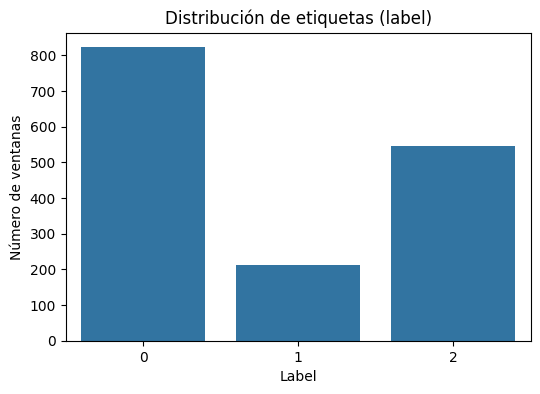

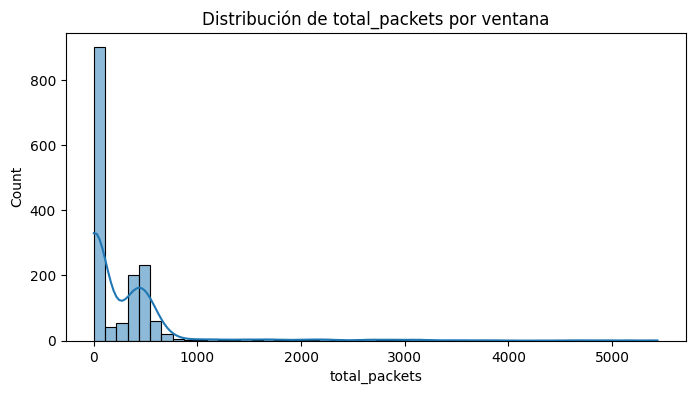

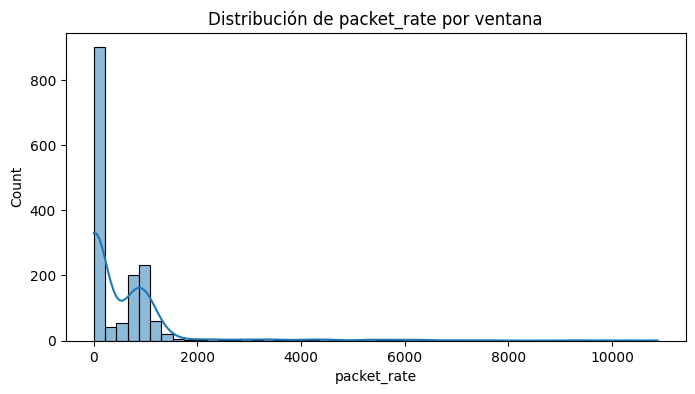

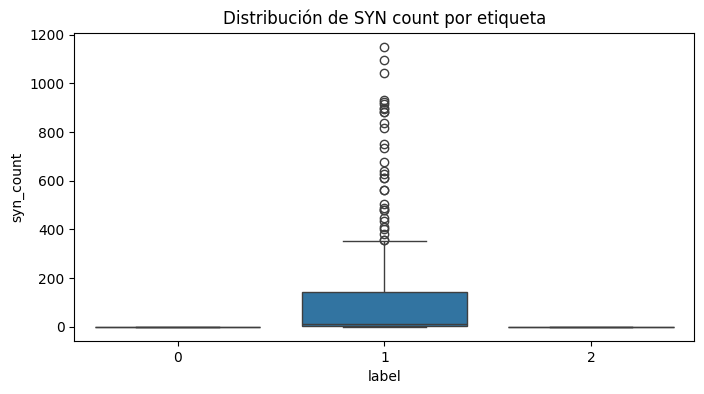

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Cargar dataset de features
# ---------------------------
df = pd.read_csv("Dataset/DoS_window_features.csv")

# ---------------------------
# Distribución de etiquetas
# ---------------------------
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title("Distribución de etiquetas (label)")
plt.xlabel("Label")
plt.ylabel("Número de ventanas")
plt.show()

# ---------------------------
# Distribución de total_packets
# ---------------------------
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='total_packets', bins=50, kde=True)
plt.title("Distribución de total_packets por ventana")
plt.show()

# ---------------------------
# Distribución de packet_rate
# ---------------------------
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='packet_rate', bins=50, kde=True)
plt.title("Distribución de packet_rate por ventana")
plt.show()

# ---------------------------
# Boxplot por label de SYN count
# ---------------------------
plt.figure(figsize=(8,4))
sns.boxplot(x='label', y='syn_count', data=df)
plt.title("Distribución de SYN count por etiqueta")
plt.show()